Import

In [18]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim  # SR 평가지표

In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Input
import os
import math

realization of evaluation index function

In [20]:
# define function for peak signal-to-noise ration (PSNR)  
def psnr(target, ref) : 
    
    # assume RGB/BGR image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255./ rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    
    # MSE is the sum of the squared fifference between the two the images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel= True))
    
    return scores

prepare degraded images by introducing quality distortions via resizing

이미지는 다운그레이드 시킨 다음에 다시 원래 사이즈로 복귀를 시킨다
   - 픽셀 수는 똑같으나 이미지가 좀 더 흐릿하게 보임

   - source폴더에 있는 원본 파일을 for문을 통하여 차례대로 가져와 resize해서 images폴더에 생성
      - 생성 후 파일 이름을 프린트

In [21]:
def prepare_images(path, factor):
    
    # loop through the file in the directory 
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [24]:
# 2로 downgraded하여 실행
prepare_images('D:/Personal Project/source/', 2)

Saving baboon.bmp
Saving barbara.bmp
Saving bridge.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving lenna.bmp
Saving man.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving zebra.bmp


In [25]:
for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate the scores
    scores = compare_images(target, ref)
    
    # print a;; three scores
    print('{}\nPSNR: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baboon.bmp
PSNR: 22.157084083442548
SSIM: 1187.1161333333334

barbara.bmp
PSNR: 25.906629837568126
SSIM: 500.65508535879627

bridge.bmp
PSNR: 25.850528790115554
SSIM: 507.1643714904785

coastguard.bmp
PSNR: 27.161600663887082
SSIM: 375.00887784090907

comic.bmp
PSNR: 23.799861502225532
SSIM: 813.2338836565096

face.bmp
PSNR: 30.99220650287191
SSIM: 155.23189718546524

flowers.bmp
PSNR: 27.454504805386147
SSIM: 350.55093922651935

foreman.bmp
PSNR: 30.14456532664372
SSIM: 188.6883483270202

lenna.bmp
PSNR: 31.47349297867539
SSIM: 138.94800567626953

man.bmp
PSNR: 27.22646369798821
SSIM: 369.4496383666992

monarch.bmp
PSNR: 30.196242365288896
SSIM: 186.45643615722656

pepper.bmp
PSNR: 29.88947161686106
SSIM: 200.1033935546875

ppt3.bmp
PSNR: 24.84926168950471
SSIM: 638.6684263912582

zebra.bmp
PSNR: 27.909840639329513
SSIM: 315.6585459528818



Define the SRCNN model

In [26]:
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # compile model
    SRCNN.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    return SRCNN
    

Define necessary image processing functions

In [27]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    img = image[border:-border, border:-border]
    return img

define main prediction function

      - degraded = 저해상도 이미지
      - output = SRCNN 이미지
      - ref = 고해상도 이미지
      - score = 비교분석

In [28]:
def predict(image_path):
    
    # load the SRCNN model with weights(SRCNN 로드)
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images(downgraded된 이미지 로드)
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with madcrop(이미지가 downgraded할 때 나눠떨어질 수 있게 만드는 함수)
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to VCrCb - (srccn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize(predict할 Y값을 4차원으로 만들고 스케일링)
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn(예측)
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output(predict이후에 다시 h,w * 255로 이미지의 형식으로 반환하기)
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR(cv2.imread로 읽어본 이미지를 원래의 컬러로 복원)
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR) 
    
    # remove border from reference and degraded image(이미지 끝을 6씩 깎기)
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality caluclations (평가지표 로드)
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores  
       

Degraded Image : 
PSNR: 22.285122135474143
MSE: 1152.628628072958
SSIM: 0.6327198184502538

Reconstructed Image : 
PSNR: 23.035629887357693
MSE: 969.7027491408935
SSIM: 0.7090942470459657



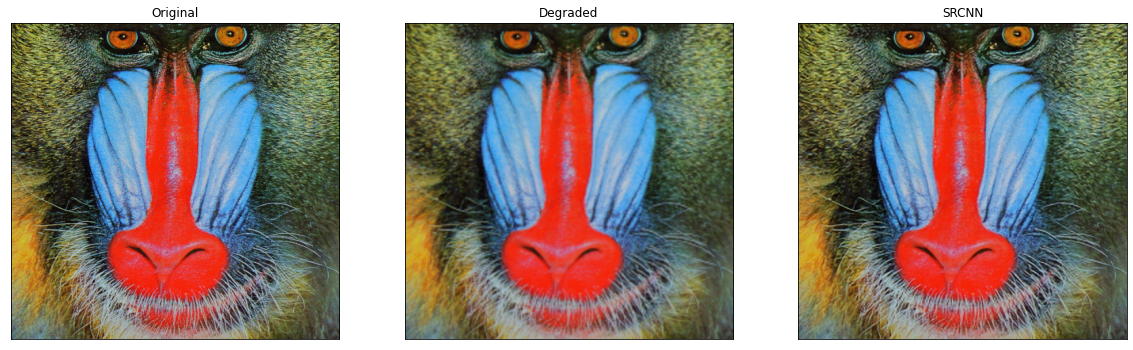

In [30]:
ref, degraded, output, scores = predict('images/baboon.bmp')

# print all scores for all images
print('Degraded Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original")
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title("Degraded")
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title("SRCNN")

# remove the x and y tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])